In [1]:
# Cell 1: Imports & Config

import os
import random
from dataclasses import dataclass
from datetime import datetime

import numpy as np
import torch

from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
)

from torch.utils.data import DataLoader
from torch.optim import AdamW

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt


def nowstamp():
    return datetime.now().strftime("%Y%m%d_%H%M%S")

@dataclass
class Config:
    # Project
    project_name: str = "distilbert_tweet_eval_sentiment"

    # Dataset
    dataset_name: str = "tweet_eval"
    dataset_config: str = "sentiment"
    text_col: str = "text"
    label_col: str = "label"

    # Model
    model_name: str = "distilbert-base-uncased"
    max_seq_len: int = 256 #128

    # Train
    batch_size: int = 16
    lr: float = 1e-5 #2e-5
    epochs: int = 3 #2

    seed: int = 42

    # Speed control (Mac向け)
    max_train_examples: int | None = 8000
    max_val_examples: int | None = 1000
    max_test_examples: int | None = 2000

    debug_max_steps_per_epoch: int | None = 300  # None で制限なし

    # Early stopping
    early_stopping_patience: int = 1

    # Output directories (絶対パス)
    root_dir: str = "/Users/mh/Downloads/Mini Project/Jan_TextClassification_Iteration"
    results_dir: str = ""
    models_dir: str = ""
    logs_dir: str = ""


cfg = Config()
cfg.results_dir = os.path.join(cfg.root_dir, "results")
cfg.models_dir   = os.path.join(cfg.root_dir, "models")
cfg.logs_dir     = os.path.join(cfg.root_dir, "logs")


os.makedirs(cfg.results_dir, exist_ok=True)
os.makedirs(cfg.models_dir, exist_ok=True)
os.makedirs(cfg.logs_dir, exist_ok=True)

print("root_dir:", cfg.root_dir)
print("results_dir:", cfg.results_dir)
print("models_dir:", cfg.models_dir)
print("logs_dir:", cfg.logs_dir)

root_dir: /Users/mh/Downloads/Mini Project/Jan_TextClassification_Iteration
results_dir: /Users/mh/Downloads/Mini Project/Jan_TextClassification_Iteration/results
models_dir: /Users/mh/Downloads/Mini Project/Jan_TextClassification_Iteration/models
logs_dir: /Users/mh/Downloads/Mini Project/Jan_TextClassification_Iteration/logs


In [2]:
# Cell 2: Seed fixed & DEVICE

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(cfg.seed)

if torch.backends.mps.is_available():
    DEVICE = "mps"
elif torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

print("DEVICE:", DEVICE)
print("torch:", torch.__version__)

DEVICE: mps
torch: 2.5.1


In [3]:
# Cell 3: Load dataset & take_n

def take_n(d, n):
    """
    Datasetを軽量化する関数。
    n が None ならそのまま、n が指定されていれば先頭 n 件だけにする。
    """
    if n is None:
        return d
    n = min(n, len(d))
    return d.select(range(n))

raw: DatasetDict = load_dataset(cfg.dataset_name, cfg.dataset_config)
print(raw)

train_ds = raw["train"]
val_ds   = raw["validation"]
test_ds  = raw["test"]

# 軽量化（Macで落ちないように）
train_ds = take_n(train_ds, cfg.max_train_examples)
val_ds   = take_n(val_ds, cfg.max_val_examples)
test_ds  = take_n(test_ds, cfg.max_test_examples)

print("sizes:", len(train_ds), len(val_ds), len(test_ds))
print("sample:", train_ds[0])

# labels info
# tweet_eval(sentiment) は label が ClassLabel のはず
label_feature = train_ds.features[cfg.label_col]
try:
    num_labels = int(label_feature.num_classes)
    label_names = label_feature.names
except Exception:
    # 万一 ClassLabel でなければ fallback
    labels = sorted(set(train_ds[cfg.label_col]))
    num_labels = len(labels)
    label_names = [str(x) for x in labels]

print("num_labels:", num_labels)
print("label_names:", label_names)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})
sizes: 8000 1000 2000
sample: {'text': '"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"', 'label': 2}
num_labels: 3
label_names: ['negative', 'neutral', 'positive']


In [4]:
# Cell 4: Tokenizer & Tokenize

tokenizer = AutoTokenizer.from_pretrained(cfg.model_name, use_fast=True)

def tokenize_batch(batch):
    return tokenizer(
        batch[cfg.text_col],
        truncation=True,
        max_length=cfg.max_seq_len,
    )

# batched=True を使うと速い & 安定
train_tok = train_ds.map(tokenize_batch, batched=True)
val_tok   = val_ds.map(tokenize_batch, batched=True)
test_tok  = test_ds.map(tokenize_batch, batched=True)

# 重要：Trainerを使わず自前DataLoaderするので、torch形式に
cols = ["input_ids", "attention_mask", cfg.label_col]
train_tok.set_format(type="torch", columns=cols)
val_tok.set_format(type="torch", columns=cols)
test_tok.set_format(type="torch", columns=cols)

print("tokenized keys:", train_tok.column_names)

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

tokenized keys: ['text', 'label', 'input_ids', 'attention_mask']


In [5]:
# Cell 5: DataLoader, Model, Optimizer

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def make_loader(ds, shuffle: bool):
    return DataLoader(
        ds,
        batch_size=cfg.batch_size,
        shuffle=shuffle,
        collate_fn=data_collator,
    )

train_loader = make_loader(train_tok, shuffle=True)
val_loader   = make_loader(val_tok, shuffle=False)
test_loader  = make_loader(test_tok, shuffle=False)

print("batch keys:", next(iter(train_loader)).keys())

model = AutoModelForSequenceClassification.from_pretrained(
    cfg.model_name,
    num_labels=num_labels,
).to(DEVICE)

optimizer = AdamW(model.parameters(), lr=cfg.lr)

print("model ready:", cfg.model_name)

import torch.nn as nn #added
criterion = nn.CrossEntropyLoss(weight=weights.to(DEVICE)) #added

batch keys: KeysView({'input_ids': tensor([[  101,  4931,  1030,  5310,  6616,  2017,  1012,  1045,  2123,  1005,
          1056,  2031,  4274,  2127,  9432,  1998,  2026, 12202,  2028,  2180,
          1005,  1056,  2130,  2292,  2033,  3696,  3031,  2026,  4070,  2125,
          4179,  1012,   102,     0,     0,     0],
        [  101,  3892,  1005,  1055,  2792,  1997,  6928,  2305,  6315,  2001,
          5507, 21358,  1010,  1996, 12648,  3337,  1010, 26220, 22012,  1010,
          1998, 12072,   999,   999,  2066, 10930,  1059,  2705,   999,   102,
             0,     0,     0,     0,     0,     0],
        [  101,  2280,  8096, 17207,  5313,  2447,  1999,  1996,  8987, 17549,
          2136,  1998,  4916,  2248,  6583,  9905, 17343, 22079,  2098,  2091,
          2197,  2305,  2648,  3290,  2103,  1012,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [  101,  2339,  2003,  3782,  8945,  4095,  2061,  6616,  2378,  1032,
         23343, 240

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model ready: distilbert-base-uncased


In [6]:
# Cell 6: eval_model

from sklearn.metrics import accuracy_score, f1_score

def eval_model(model, dataloader):
    """
    dataloader 全体に対して
      - 平均 loss
      - accuracy
      - macro F1
      - all_labels, all_preds
    を返す。
    """

    # 0) （デバッグ）dataloader が返す batch のキーを1回だけ確認
    try:
        first_batch = next(iter(dataloader))
        print("[eval_model] batch keys:", first_batch.keys())
    except StopIteration:
        raise ValueError("dataloader is empty (no batches).")

    # 1) model を eval モードにする
    model.eval()

    # 2) 正解ラベル・予測ラベル用リスト
    all_labels = []
    all_preds  = []

    # 3) loss 用カウンタ
    total_loss = 0.0
    n_steps = 0

    # 4) 勾配は不要
    with torch.no_grad():
        for batch in dataloader:

            # 4-1) バッチを DEVICE に載せる
            batch = {k: v.to(DEVICE) for k, v in batch.items()}

            # 4-2) 順伝播
            out = model(**batch)

            # 4-3) loss 蓄積
            loss = out.loss
            total_loss += float(loss.item())
            n_steps += 1

            # 4-4) 予測ラベル
            logits = out.logits
            preds = logits.argmax(dim=-1)

            # 4-5) labels キー名を吸収する（labels / label 両対応）
            if "labels" in batch:
                labels = batch["labels"]
            elif "label" in batch:
                labels = batch["label"]
            else:
                raise KeyError(f"batch has no labels key. keys={list(batch.keys())}")

            # CPU に戻して list に追加
            all_labels.extend(labels.detach().cpu().numpy().tolist())
            all_preds.extend(preds.detach().cpu().numpy().tolist())

    # 5) 平均 loss
    avg_loss = total_loss / max(1, n_steps)

    # 6) 精度と F1（macro）
    acc = accuracy_score(all_labels, all_preds)
    f1  = f1_score(all_labels, all_preds, average="macro")

    # 7) まとめて返す
    return avg_loss, acc, f1, all_labels, all_preds

In [7]:
# Cell 7: Training loop (logging + early stopping)

from tqdm.auto import tqdm
import torch

ts = nowstamp()
run_name = f"{cfg.project_name}_{ts}"
save_dir = os.path.join(cfg.models_dir, run_name)
os.makedirs(save_dir, exist_ok=True)

log_path = os.path.join(cfg.logs_dir, f"train_log_{ts}.tsv")
print("Save dir:", save_dir)
print("Log   :", log_path)

# 1) ログヘッダ
with open(log_path, "w") as f:
    f.write("epoch\tsteps\ttrain_loss\tval_loss\tval_acc\tval_f1\n")

best_val_loss = float("inf")
epochs_no_improve = 0

for ep in range(1, cfg.epochs + 1):
    # 2) train モード
    model.train()

    # 3) loss集計用
    total_loss = 0.0
    n_steps = 0

    # 4) tqdm
    progress = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {ep}/{cfg.epochs}")

    for step, batch in enumerate(progress):
        # 4-1) DEVICEへ
        batch = {k: v.to(DEVICE) for k, v in batch.items()}

        # 4-2) optimizer.zero_grad()
        optimizer.zero_grad()

        # 4-3) forward
        out = model(**batch)
        logits = out.logits  # [B, num_labels]

        # 4-4) labels を吸収（labels / label どちらでもOK）
        labels = batch["labels"] if "labels" in batch else batch["label"]

        # 4-5) ★重み付きloss
        loss = criterion(logits, labels)

        # 4-6) backward
        loss.backward()

        # 4-7) clip + step
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # 4-8) 集計
        total_loss += float(loss.item())
        n_steps += 1

        # 4-9) tqdm表示
        progress.set_postfix({"loss": float(loss.item())})

        # 4-10) debug step limit
        if cfg.debug_max_steps_per_epoch is not None and (step + 1) >= cfg.debug_max_steps_per_epoch:
            break

    # 5) train_loss（←ここは “for step” の外）
    train_loss = total_loss / max(1, n_steps)

    # 6) val eval
    val_loss, val_acc, val_f1, _, _ = eval_model(model, val_loader)

    # 7) MPS cache clear（epoch単位）
    if DEVICE == "mps":
        torch.mps.empty_cache()

    # 8) print
    print(
        f"\nEpoch {ep}/{cfg.epochs} steps={n_steps} "
        f"train_loss={train_loss:.4f} val_loss={val_loss:.4f} "
        f"val_acc={val_acc:.4f} val_f1={val_f1:.4f}"
    )

    # 9) log append
    with open(log_path, "a") as f:
        f.write(f"{ep}\t{n_steps}\t{train_loss:.6f}\t{val_loss:.6f}\t{val_acc:.6f}\t{val_f1:.6f}\n")

    # 10) early stopping + save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        model.save_pretrained(save_dir)
        tokenizer.save_pretrained(save_dir)
        print("  -> best model updated & saved.")
    else:
        epochs_no_improve += 1
        print(f"  -> no improvement ({epochs_no_improve}/{cfg.early_stopping_patience})")
        if epochs_no_improve >= cfg.early_stopping_patience:
            print("  -> Early stopping triggered.")
            break

Save dir: /Users/mh/Downloads/Mini Project/Jan_TextClassification_Iteration/models/distilbert_tweet_eval_sentiment_20260109_062409
Log   : /Users/mh/Downloads/Mini Project/Jan_TextClassification_Iteration/logs/train_log_20260109_062409.tsv


Epoch 1/3:   0%|          | 0/500 [00:00<?, ?it/s]

[eval_model] batch keys: KeysView({'input_ids': tensor([[  101,  2601,  9293,  1017,  2258,  4888,  3058,  4484,  2007,  2047,
          9117,  1024,  9979,  1996,  4768,  1012,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  1000,  2120,  2980,  3899,  2154,  1010,  2120, 26791,  2154,
          1010,  2059,  2120,  3153,  2154,  1012,  1012,  1012,  4165,  2066,
          1037,  5958,  2305,  1012,  1000,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  2043,  3057,  2468,  2316,  4213,  7446,  4599,  1997,  1996,
         15285,  2138,  1997,  4302,  1012,  2079,  1061,  1005,  2035,  2130,
          2113, 

Epoch 2/3:   0%|          | 0/500 [00:00<?, ?it/s]

[eval_model] batch keys: KeysView({'input_ids': tensor([[  101,  2601,  9293,  1017,  2258,  4888,  3058,  4484,  2007,  2047,
          9117,  1024,  9979,  1996,  4768,  1012,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  1000,  2120,  2980,  3899,  2154,  1010,  2120, 26791,  2154,
          1010,  2059,  2120,  3153,  2154,  1012,  1012,  1012,  4165,  2066,
          1037,  5958,  2305,  1012,  1000,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  2043,  3057,  2468,  2316,  4213,  7446,  4599,  1997,  1996,
         15285,  2138,  1997,  4302,  1012,  2079,  1061,  1005,  2035,  2130,
          2113, 

Epoch 3/3:   0%|          | 0/500 [00:00<?, ?it/s]

[eval_model] batch keys: KeysView({'input_ids': tensor([[  101,  2601,  9293,  1017,  2258,  4888,  3058,  4484,  2007,  2047,
          9117,  1024,  9979,  1996,  4768,  1012,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  1000,  2120,  2980,  3899,  2154,  1010,  2120, 26791,  2154,
          1010,  2059,  2120,  3153,  2154,  1012,  1012,  1012,  4165,  2066,
          1037,  5958,  2305,  1012,  1000,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  2043,  3057,  2468,  2316,  4213,  7446,  4599,  1997,  1996,
         15285,  2138,  1997,  4302,  1012,  2079,  1061,  1005,  2035,  2130,
          2113, 

[eval_model] batch keys: KeysView({'input_ids': tensor([[  101,  1030,  5310,  1030,  5310,  2054,  2079,  2122,  1005,  1015,
          1013,  1016,  6248, 27263,  2015,  1005,  2031,  2000,  2079,  2007,
          2505,  1029,  2027,  1005,  2128,  2025,  2130,  2066,  2008,  1012,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0],
        [  101,  2821,  1024,  1523,  1045,  2018,  1037,  2630, 19085,  2096,
          1045,  2001,  2023,  1524,  1031,  2652,  2007,  8224,  3011, 27830,
          1033,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0],
        [  101,  1030,  5310,  1030,  5310,  2008,  1005,  1055,  2746,  1010,
          2021,  1045,  2228,  1996,  5694,  2024,  2183,  2000,  2022, 19960,
          5555,  3593, 15991,  1012,   102,     0,     0,     0,     0,     0,
       

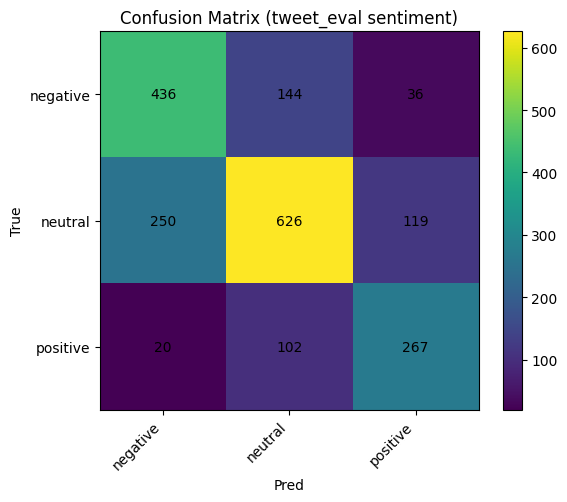

confusion matrix saved: /Users/mh/Downloads/Mini Project/Jan_TextClassification_Iteration/results/confusion_matrix_20260109_062409.png

[Artifacts]
best model dir: /Users/mh/Downloads/Mini Project/Jan_TextClassification_Iteration/models/distilbert_tweet_eval_sentiment_20260109_062409
train log     : /Users/mh/Downloads/Mini Project/Jan_TextClassification_Iteration/logs/train_log_20260109_062409.tsv
errors.tsv    : /Users/mh/Downloads/Mini Project/Jan_TextClassification_Iteration/results/errors_20260109_062409.tsv
cm.png        : /Users/mh/Downloads/Mini Project/Jan_TextClassification_Iteration/results/confusion_matrix_20260109_062409.png


In [8]:
# Cell 8: Test eval + errors.tsv + Confusion Matrix

# 1) Test評価
test_loss, test_acc, test_f1, y_true, y_pred = eval_model(model, test_loader)
print("\n[Test]")
print(f"loss={test_loss:.4f} acc={test_acc:.4f} f1_macro={test_f1:.4f}")

# 2) Classification report（ラベル名があるなら表示）
try:
    print("\n[Classification Report]")
    print(classification_report(y_true, y_pred, target_names=label_names))
except Exception:
    print("\n[Classification Report]")
    print(classification_report(y_true, y_pred))

# 3) errors.tsv（誤分類サンプルを保存）
errors_path = os.path.join(cfg.results_dir, f"errors_{ts}.tsv")

# test_ds は token化前の生データがあるので、それと整合するように注意：
# take_n & map の順が同じなので、indexは一致する想定
with open(errors_path, "w") as f:
    f.write("idx\ttrue_id\tpred_id\ttrue_label\tpred_label\ttext\n")
    for i, (yt, yp) in enumerate(zip(y_true, y_pred)):
        if yt != yp:
            ex = test_ds[i]
            true_name = label_names[yt] if yt < len(label_names) else str(yt)
            pred_name = label_names[yp] if yp < len(label_names) else str(yp)
            text = ex[cfg.text_col].replace("\t", " ").replace("\n", " ")
            f.write(f"{i}\t{yt}\t{yp}\t{true_name}\t{pred_name}\t{text}\n")

print("errors.tsv saved:", errors_path)

# 4) Confusion Matrix plot 保存
cm = confusion_matrix(y_true, y_pred)
fig = plt.figure(figsize=(6, 5))
plt.imshow(cm)
plt.title("Confusion Matrix (tweet_eval sentiment)")
plt.xlabel("Pred")
plt.ylabel("True")
plt.xticks(range(len(label_names)), label_names, rotation=45, ha="right")
plt.yticks(range(len(label_names)), label_names)
plt.colorbar()

# 値も表示
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.tight_layout()
cm_path = os.path.join(cfg.results_dir, f"confusion_matrix_{ts}.png")
plt.savefig(cm_path, dpi=200)
plt.show()

print("confusion matrix saved:", cm_path)

# 5) どこに何が出たか、最終まとめ
print("\n[Artifacts]")
print("best model dir:", save_dir)
print("train log     :", log_path)
print("errors.tsv    :", errors_path)
print("cm.png        :", cm_path)

In [9]:
import pandas as pd

errors = pd.read_csv("results/errors_20260109_062409.tsv", sep="\t")

# 真のラベル × 予測ラベル
ct = pd.crosstab(errors["true_label"], errors["pred_label"])
ct

pred_label,negative,neutral,positive
true_label,,,
negative,0,144,36
neutral,250,0,119
positive,20,102,0


In [12]:
import pandas as pd

pd.set_option("display.max_colwidth", None)     # 切り捨てない
pd.set_option("display.max_rows", 50)           # 必要なら増やす
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 200)             # 表示幅（効かなければ次へ）

In [13]:
errors[
    (errors["true_label"] == "neutral") &
    (errors["pred_label"] == "negative")
].sample(10)[["text", "true_label", "pred_label"]]

,text,true_label,pred_label
430,Remember The Pretty White Girls Who Became #ISIS Terrorists?You May Wanna Take A Look At Them Now....#OpISIS...,neutral,negative
599,termites release far more CO2 annually (and by several orders of magnitude) than all the burning of fossil fuels.https://t.co/3BJAsYk8JC,neutral,negative
166,"We have lost everything: Syrians return to ravaged Aleppo, @user reports. by #AP via @user",neutral,negative
663,Fidel Castro's last wish was no monuments in his name.,neutral,negative
478,"@user no I believe u, not denying there was testing on woc. I'm saying animal rts ppl wouldnt support it, which the tweet implies",neutral,negative
364,"@user tony romo couldn't, you're right, but that's just bc they'd rely too heavily on the QB in stead of the run game.",neutral,negative
150,"Is #Ukraine headed for another revolution? #Saakashvili who resigned the Kiev govt because of corruption, thinks yes",neutral,negative
129,Ahmed lost his home to IS. #MosulOffensive,neutral,negative
93,"@user Imagining a credible threat, can they force him to sit down for the briefing? ""Look son, some bad hombres wanna get you...""0",neutral,negative
133,8 Dangerous Side Effects of Fracking That the Industry Doesn't Want You to Hear About | Alternethttps://t.co/NknAwg0MV4,neutral,negative


In [14]:
errors[
    (errors["true_label"] == "negative") &
    (errors["pred_label"] == "neutral")
].sample(10)[["text", "true_label", "pred_label"]]

,text,true_label,pred_label
264,"Omfg in china they call kim jong un ""kim fatty the third""",negative,neutral
667,Of course #clownshoes #altright #IllinoisNazis,negative,neutral
529,@user @user & to this day every convo w/ Berner you have to redefine 'voter suppression' before we can continue.,negative,neutral
294,"President-elect Trump could make big bucks from Dakota Access Pipeline, @user reports",negative,neutral
176,Sharon needles is doing Melania trump n the crowd is chanting CULEERAA,negative,neutral
365,Charles rails on bible thumping conservatives all the time and I find it funny because they're always taken a back that a veteran is going—,negative,neutral
27,"@user it's free with insurance because of Obamacare, which trump wants to repeal 🙃",negative,neutral
232,"Steve Bannon look like the type of dude to hang out in front of liquor stores all day handing out ""Hillary is Satan…",negative,neutral
5,@user @user @user @user @user @user take away illegals and dead people and Trump wins popular vote too.,negative,neutral
371,Pop is gay for Tim Duncan,negative,neutral


In [19]:
import pandas as pd

def make_insights_block(errors_df: pd.DataFrame, topn: int = 5) -> str:
    # クロスタブ（誤分類だけ）
    ct = pd.crosstab(errors_df["true_label"], errors_df["pred_label"])
    flat = ct.stack().sort_values(ascending=False)
    top = flat.head(topn)

    lines = []
    lines.append("## 5️⃣ Error analysis (from `errors.tsv`)")
    lines.append("")
    lines.append("### Most frequent error patterns")
    for (true_lbl, pred_lbl), n in top.items():
        lines.append(f"- **true={true_lbl} → pred={pred_lbl}** : **{int(n)}** samples")

    lines.append("")
    lines.append("### Interpretation (practical)")
    lines.append("- Errors concentrate around borderline cases (especially involving **neutral**).")
    lines.append("- Many samples contain *keywords* that look negative/positive, but the overall intent is neutral → the model may over-rely on surface cues.")
    lines.append("")
    lines.append("### Next actions")
    lines.append("- Apply **class weights** (increase weight for `neutral`) and retrain.")
    lines.append("- Add “human-ambiguous examples” to README to justify remaining errors.")
    return "\n".join(lines)

insights_md = make_insights_block(errors, topn=5)
print(insights_md)

## 5️⃣ Error analysis (from `errors.tsv`)

### Most frequent error patterns
- **true=neutral → pred=negative** : **250** samples
- **true=negative → pred=neutral** : **144** samples
- **true=neutral → pred=positive** : **119** samples
- **true=positive → pred=neutral** : **102** samples
- **true=negative → pred=positive** : **36** samples

### Interpretation (practical)
- Errors concentrate around borderline cases (especially involving **neutral**).
- Many samples contain *keywords* that look negative/positive, but the overall intent is neutral → the model may over-rely on surface cues.

### Next actions
- Apply **class weights** (increase weight for `neutral`) and retrain.
- Add “human-ambiguous examples” to README to justify remaining errors.


In [20]:
out_path = "results/insights_from_errors.md"
with open(out_path, "w", encoding="utf-8") as f:
    f.write(insights_md)

print("saved:", out_path)

saved: results/insights_from_errors.md


In [21]:
from collections import Counter
import torch

label_col = cfg.label_col  # たとえば "label" のはず
counts = Counter(train_ds[label_col])
counts

Counter({1: 3636, 2: 3130, 0: 1234})

In [22]:
# ラベルIDは 0..(num_labels-1) を仮定
num_labels = len(set(train_ds[label_col]))

freq = torch.tensor([counts[i] for i in range(num_labels)], dtype=torch.float)
weights = 1.0 / (freq + 1e-9)
weights = weights / weights.mean()  # 平均1に正規化（扱いやすい）

weights

tensor([1.7305, 0.5873, 0.6822])